In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import json
import math
import requests
import numpy as np
import seaborn as sns
import matplotlib.pylab as pylab

params = {'legend.fontsize': '17',
          'figure.figsize': (20, 10),
         'axes.labelsize': '18',
         'axes.titlesize':'21',
         'xtick.labelsize':'17',
         'ytick.labelsize':'17'}
pylab.rcParams.update(params)

pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
def get_vehicle_id(year, make, model):
    response = requests.get('https://webapi.nhtsa.gov/api/SafetyRatings/modelyear/%s/make/%s/model/%s?format=json' % (year, make, model))
    if response.status_code == 200:
        json_response = response.json()
        print(json_response['Message'])
        if int(json_response['Count']) > 0:
            return json_response['Results'][0]['VehicleId']
    else:
        print ('API request failed.', response.status_code)
    return '-1'

In [3]:
df_tests = pd.read_csv('data/test.psv', sep = '|', encoding = 'unicode_escape')
df_vehicles = pd.read_csv('data/veh.psv', sep = '|', encoding = 'unicode_escape')
df_uk_accidents = pd.read_csv('data/uk_accidents.csv', encoding = 'unicode_escape')
df_uk_vehicles = pd.read_csv('data/uk_vehicles.csv', encoding = 'unicode_escape')
df_uk_casualties = pd.read_csv('data/uk_casualties.csv', encoding = 'unicode_escape')
df_uk_makes = pd.read_csv('data/Vehicle_Information.csv', usecols = [0, 10, 11, 19], encoding = 'unicode_escape')

/home/tarek/L4L/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/tarek/L4L/.venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Appending makes and models to the UK vehicles DF
if 'Vehicle_Make' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_makes, on = ['Accident_Index', 'Vehicle_Reference'], how='left')
    
# Rename vehicle make, model to follow the same convention
df_uk_vehicles.rename(columns={'make': 'Vehicle_Make', 'model': 'Vehicle_Model'}, inplace = True)


# Mapping numeric values to corresponding text
df_uk_vehicles_map = {
    'Engine_Capacity_(CC)': {-1: np.nan},
    'Sex_of_Driver': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Age_Band_of_Driver': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'}, 
    'Vehicle_Make': {'MISSING': np.nan},
    'Vehicle_Model': {'MISSING': np.nan},
    'Age_of_Vehicle': {-1: np.nan},
    '1st_Point_of_Impact': {-1: np.nan, 1: 'Front', 2: 'Back', 3: 'Offside', 4: 'Nearside'},
    'Vehicle_Manoeuvre': {-1: np.nan, 1: 'Reversing', 2: 'Parked', 3: 'Waiting to go - held up', 4: 'Slowing or stopping', 5: 'Moving off', 6: 'U-turn', 7: 'Turning left', 8: 'Waiting to turn left', 9: 'Turning right', 10: 'Waiting to turn right', 11: 'Changing lane to left', 12: 'Changing lane to right', 13: 'Overtaking moving vehicle – offside', 14: 'Overtaking static vehicle - offside', 15: 'Overtaking - nearside', 16: 'Going ahead left-hand bend', 17: 'Going ahead right-hand bend', 18: 'Going ahead other'},
    'Vehicle_Type': {-1: np.nan, 90: np.nan, 1: 'Pedal cycle', 2: 'Motorcycle <=50cc', 3: 'Motorcycle <=125cc', 4: 'Motorcycle 125cc-500cc', 5: 'Motorcycle >500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8-16 seats)', 11: 'Bus (>=17 seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van <=3.5 t.', 20: 'Goods 3.5t.-7.5t', 21: 'Goods >=7.5 t.', 22: 'Mobility scooter', 23: 'Electric motorcycle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight'}
}
df_uk_accidents_map = {
    'Accident_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Weather_Conditions': {-1: np.nan, 8: np.nan, 9: np.nan, 1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or mist'},
    'Light_Conditions': {-1: np.nan, 1: 'Daylight', 4: 'Darkness - lights lit', 5: 'Darkness - lights unlit', 6: 'Darkness - no lighting', 7: 'Darkness - lighting unknown'}
}
df_uk_casualties_map = {
    'Casualty_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Sex_of_Casualty': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Casualty_Class': {-1: np.nan, 1: 'Driver or rider', 2: 'Passenger', 3: 'Pedestrian'}
}


for key in df_uk_vehicles_map:
    for old_value in df_uk_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_uk_vehicles_map[key][old_value])
for key in df_uk_accidents_map:
    for old_value in df_uk_accidents_map[key]:
        df_uk_accidents[key] = df_uk_accidents[key].replace(old_value, df_uk_accidents_map[key][old_value])
for key in df_uk_casualties_map:
    for old_value in df_uk_casualties_map[key]:
        df_uk_casualties[key] = df_uk_casualties[key].replace(old_value, df_uk_casualties_map[key][old_value])

# Converting UK Accident_Index to string
df_uk_vehicles.Accident_Index = df_uk_vehicles.Accident_Index.astype(str)
df_uk_accidents.Accident_Index = df_uk_accidents.Accident_Index.astype(str)
df_uk_casualties.Accident_Index = df_uk_casualties.Accident_Index.astype(str)

# Converting UK number columns to floats
df_uk_vehicles.Age_of_Vehicle = df_uk_vehicles.Age_of_Vehicle.astype(float)

# Calculating vehicle year from age_of_vehicle and accident date
if 'Vehicle_Year' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_accidents[['Accident_Index', 'Date']], on = ['Accident_Index'], how='left')
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles.Date.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'].astype(float)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'] - df_uk_vehicles.Age_of_Vehicle  
    
# Dropping unneccessary columns
df_uk_vehicles.drop(columns = ['Date', 'Towing_and_Articulation', 'Was_Vehicle_Left_Hand_Drive?', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile'], inplace = True, errors = 'ignore')
df_uk_accidents.drop(columns = ['Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], inplace = True, errors = 'ignore')
df_uk_casualties.drop(columns = ['Casualty_Home_Area_Type', 'Casualty_IMD_Decile'], inplace = True, errors = 'ignore')

KeyboardInterrupt: 

In [ ]:
car_accident_indicies = df_uk_vehicles[(df_uk_vehicles.Vehicle_Type == 'Car') | (df_uk_vehicles.Vehicle_Type == 'Van <=3.5 t.')].Accident_Index.unique()
df_uk_vehicles = df_uk_vehicles[df_uk_vehicles.Accident_Index.isin(car_accident_indicies)]
df_uk_accidents = df_uk_accidents[df_uk_accidents.Accident_Index.isin(car_accident_indicies)]
df_uk_casualties = df_uk_casualties[df_uk_casualties.Accident_Index.isin(car_accident_indicies)]

In [ ]:
df_matched_vehicles = pd.read_csv('matched_vehicles.csv', encoding = 'unicode_escape')

In [ ]:
# additional preprocessing for veh
df_vehicles_map = {
    'Engine_Capacity_(CC)': {-1: np.nan}
}


for key in df_vehicles_map:
    for old_value in df_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_vehicles_map[key][old_value])
        df_matched_vehicles[key] = df_matched_vehicles[key].replace(old_value, df_vehicles_map[key][old_value])

In [ ]:
df_uk_vehicles.head(100)

In [ ]:
df_uk_casualties.head()

In [ ]:
df_uk_accidents.head()

## Comparison of casualty severity over the production years of the cars

In [8]:
df_vehicles_filtered = df_uk_vehicles[(df_uk_vehicles.Vehicle_Type == 'Car') | (df_uk_vehicles.Vehicle_Type == 'Van <=3.5 t.')]
df_vehicles_casualties = pd.merge(df_uk_casualties, df_vehicles_filtered, on = ['Accident_Index', 'Vehicle_Reference'], how='left')

df_plot_slight = df_vehicles_casualties[df_vehicles_casualties.Casualty_Severity == 'Slight'][['Vehicle_Year', 'Casualty_Severity']]
df_plot_slight = pd.value_counts(df_plot_slight['Vehicle_Year']).reset_index()
df_plot_slight.columns = ['Vehicle_Year', 'Count']
df_plot_slight = df_plot_slight.sort_values(by='Vehicle_Year', ascending=True)

df_plot_serious = df_vehicles_casualties[df_vehicles_casualties.Casualty_Severity == 'Serious'][['Vehicle_Year', 'Casualty_Severity']]
df_plot_serious = pd.value_counts(df_plot_serious['Vehicle_Year']).reset_index()
df_plot_serious.columns = ['Vehicle_Year', 'Count']
df_plot_serious = df_plot_serious.sort_values(by='Vehicle_Year', ascending=True)

df_plot_fatal = df_vehicles_casualties[df_vehicles_casualties.Casualty_Severity == 'Fatal'][['Vehicle_Year', 'Casualty_Severity']]
df_plot_fatal = pd.value_counts(df_plot_fatal['Vehicle_Year']).reset_index()
df_plot_fatal.columns = ['Vehicle_Year', 'Count']
df_plot_fatal = df_plot_fatal.sort_values(by='Vehicle_Year', ascending=True)

In [9]:
# divide each casualty counts by the number of accidents per year

accidents_per_year = pd.value_counts(df_vehicles_casualties[['Vehicle_Year', 'Accident_Index']]['Vehicle_Year']).reset_index()
accidents_per_year.columns = ['Vehicle_Year', 'Count']

for i in range(int(accidents_per_year.Vehicle_Year.min()), int(accidents_per_year.Vehicle_Year.max()) + 1):
    if len(accidents_per_year[accidents_per_year.Vehicle_Year == i]) > 0:
        yearly_accidents = (accidents_per_year[accidents_per_year.Vehicle_Year == i].Count.iloc[0])
    
    if len(df_plot_slight[df_plot_slight.Vehicle_Year == i]) > 0:
        df_plot_slight.Count = np.where(df_plot_slight.Vehicle_Year == i, df_plot_slight.Count / yearly_accidents, df_plot_slight.Count)
    
    if len(df_plot_serious[df_plot_serious.Vehicle_Year == i]) > 0:
        df_plot_serious.Count = np.where(df_plot_serious.Vehicle_Year == i, df_plot_serious.Count / yearly_accidents, df_plot_serious.Count)
    
    if len(df_plot_fatal[df_plot_fatal.Vehicle_Year == i]) > 0:
        df_plot_fatal.Count = np.where(df_plot_fatal.Vehicle_Year == i, df_plot_fatal.Count / yearly_accidents, df_plot_fatal.Count)

df_plot_slight.Vehicle_Year = df_plot_slight.Vehicle_Year.astype(int)
df_plot_serious.Vehicle_Year = df_plot_serious.Vehicle_Year.astype(int)
df_plot_fatal.Vehicle_Year = df_plot_fatal.Vehicle_Year.astype(int)

In [243]:
print(accidents_per_year[accidents_per_year['Vehicle_Year'] > 1987].Count.sum())
with pd.option_context('display.max_rows', 999):
    display(yearly_accidents)

1528580


8322

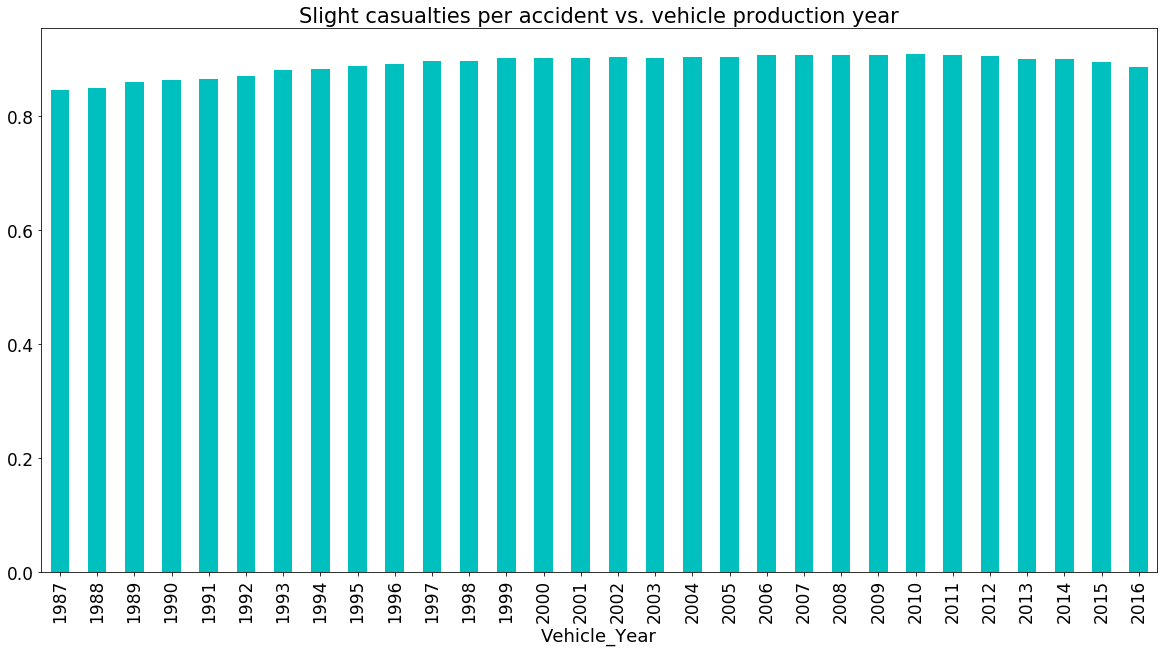

In [197]:
df_plot_slight.tail(30).plot(kind='bar',
                            x='Vehicle_Year',
                            y='Count',
                            figsize=(20,10),
                            fontsize=17,
                            legend=False,
                            color='c',
                            title='Slight casualties per accident vs. vehicle production year')

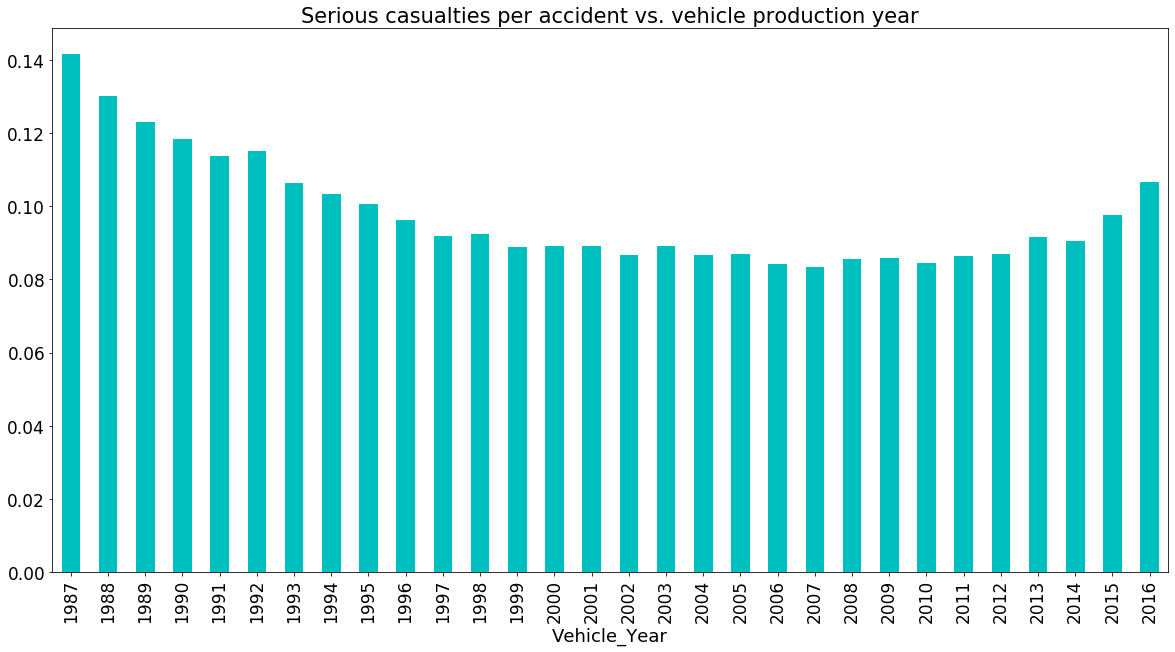

In [198]:
df_plot_serious.tail(30).plot(kind='bar',
                            x='Vehicle_Year',
                            y='Count',
                            figsize=(20,10),
                            fontsize=17,
                            legend=False,
                            color='c',
                            title='Serious casualties per accident vs. vehicle production year')

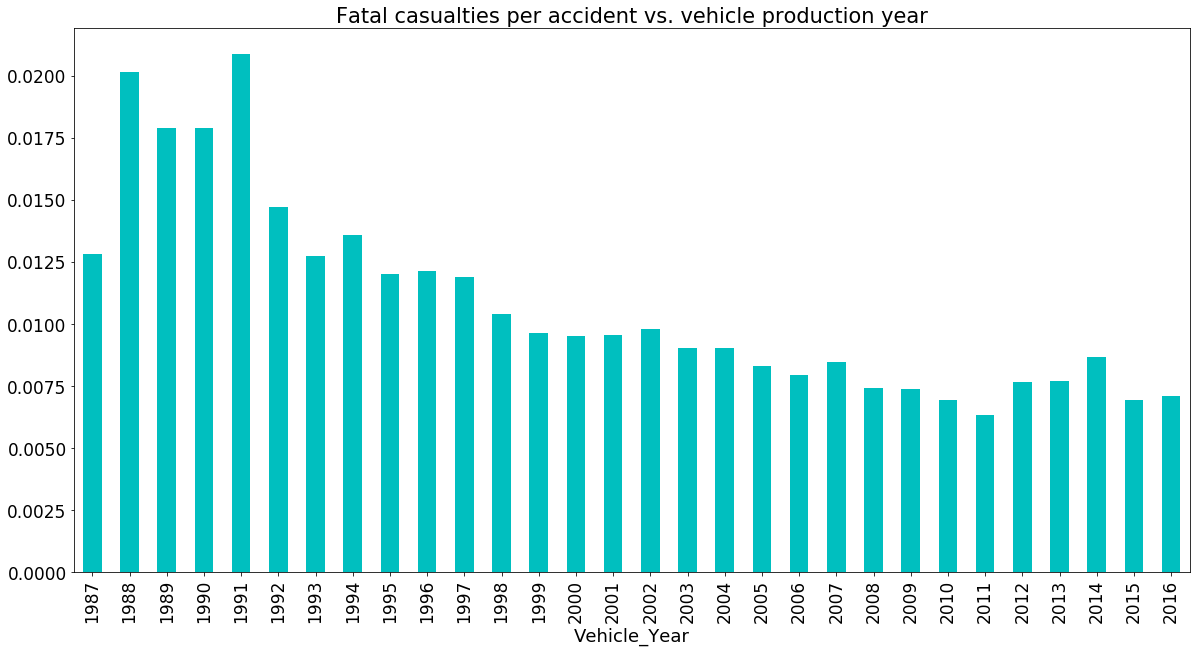

In [199]:
df_plot_fatal.tail(30).plot(kind='bar',
                            x='Vehicle_Year',
                            y='Count',
                            figsize=(20,10),
                            fontsize=17,
                            legend=False,
                            color='c',
                            title='Fatal casualties per accident vs. vehicle production year')

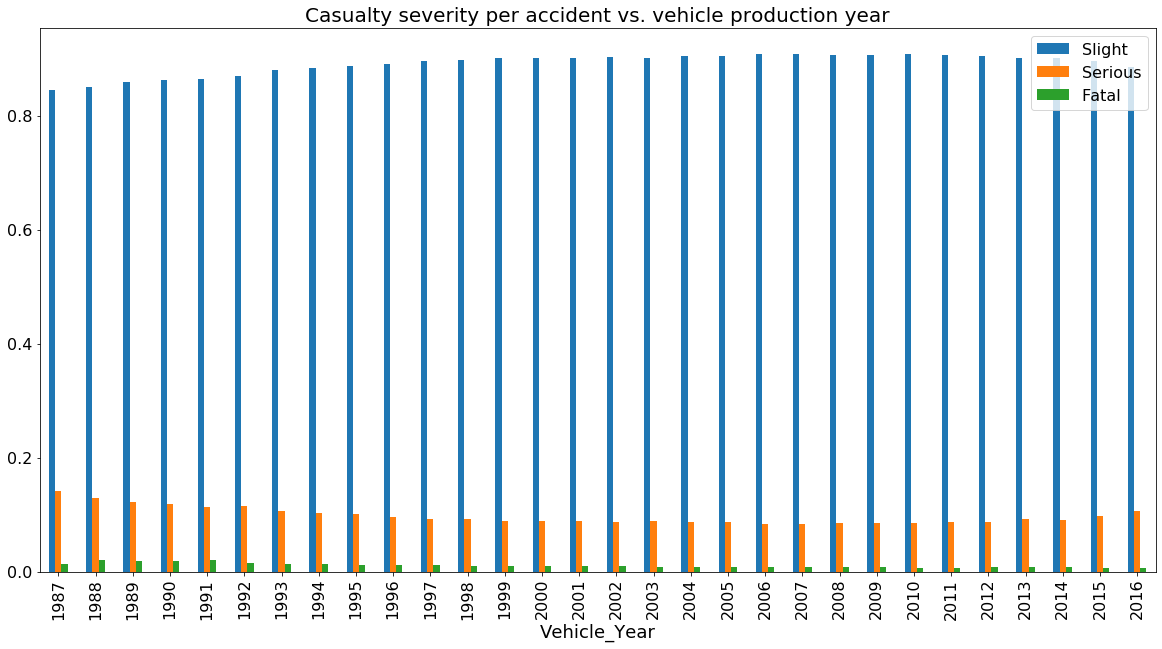

In [262]:
df_combined_temp = pd.merge(df_plot_slight, df_plot_serious, how='outer', on=['Vehicle_Year'])
df_combined = pd.merge(df_combined_temp, df_plot_fatal, how='outer', on=['Vehicle_Year'])
df_combined.columns = ['Vehicle_Year', 'Slight', 'Serious', 'Fatal']
df_combined = df_combined.sort_values(by='Vehicle_Year')
df_combined.tail(30).plot(kind='bar',
                          x='Vehicle_Year',
                          logy=False,
                          title='Casualty severity per accident vs. vehicle production year')

### Serious and fatal casualty counts per accident for cars with more than 100 collisions


In [15]:
df_vehicles_filtered = df_uk_vehicles[(df_uk_vehicles.Vehicle_Type == 'Car') | (df_uk_vehicles.Vehicle_Type == 'Van <=3.5 t.')]
df_vehicles_casualties = pd.merge(df_uk_casualties, df_vehicles_filtered, on = ['Accident_Index', 'Vehicle_Reference'], how='left')

df_casualty_cars = df_vehicles_casualties[(df_vehicles_casualties.Vehicle_Model.notnull()) & (df_vehicles_casualties.Vehicle_Make.notnull())]
df_casualty_cars = df_casualty_cars[(df_casualty_cars.Casualty_Severity == 'Serious') | (df_casualty_cars.Casualty_Severity == 'Fatal')]

accidents_per_model = pd.value_counts(df_vehicles_filtered['Vehicle_Model']).reset_index()
accidents_per_model.columns = ['Vehicle_Model', 'Accident_Count']

casualties_per_model = df_casualty_cars[['Vehicle_Model', 'Casualty_Severity']].groupby('Vehicle_Model').count().reset_index()
casualties_per_model.columns = ['Vehicle_Model', 'Severe_Casualty_Count']

df_severe_casualties = pd.merge(accidents_per_model, casualties_per_model, on='Vehicle_Model')
df_severe_casualties['Severe_Casualties_Per_Accident'] = df_severe_casualties.Severe_Casualty_Count / df_severe_casualties.Accident_Count
df_severe_casualties = df_severe_casualties.merge(df_vehicles_filtered[['Vehicle_Make', 'Vehicle_Model']].drop_duplicates('Vehicle_Model'), on='Vehicle_Model', how = 'left')
df_severe_casualties = df_severe_casualties[['Vehicle_Make','Vehicle_Model','Accident_Count','Severe_Casualty_Count','Severe_Casualties_Per_Accident']]

In [13]:
df_severe_casualties = df_severe_casualties.sort_values(by='Severe_Casualties_Per_Accident', ascending = False)
display(df_severe_casualties[df_severe_casualties.Accident_Count >= 100].head(11))

,Vehicle_Make,Vehicle_Model,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident
1918,NISSAN,SKYLINE GT-R,100,25,0.250
2263,SEAT,IBIZA CUPRA 20VT,140,33,0.236
2453,ROVER,200 VI,104,22,0.212
2466,SUBARU,IMPREZA WRX TURBO,163,34,0.209
2474,BMW,M5,111,23,0.207
2483,PEUGEOT,206 GTI,440,90,0.205
2487,HONDA,CIVIC TYPE - R,113,23,0.204
2490,CITROEN,SAXO VTS,282,57,0.202
2922,FIAT,COUPE 20V TURBO,124,24,0.194
2924,VOLKSWAGEN,GOLF VR6,176,34,0.193


In [16]:
df_severe_casualties = df_severe_casualties.sort_values(by='Severe_Casualties_Per_Accident', ascending = True)
display(df_severe_casualties[df_severe_casualties.Accident_Count >= 100].head(11))

,Vehicle_Make,Vehicle_Model,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident
3118,MERCEDES,C180 AVANTGARDE AUTO,106,1,0.009
3191,VOLKSWAGEN,PASSAT SEL TDI,103,1,0.010
3190,SAAB,9-5 SE,103,1,0.010
3292,MERCEDES,CLK200 K AVANTGARDE AUTO,100,1,0.010
2000,BMW,X5 XDRIVE30D AC AUTO,164,2,0.012
2131,MERCEDES,CLK270 CDI AVAN'DE A,155,2,0.013
2153,CITROEN,C5 VTR+ HDI,153,2,0.013
1521,TOYOTA,AVENSIS CDX VVT-I,215,3,0.014
2356,VOLKSWAGEN,PASSAT SE TDI TIPTRONIC,141,2,0.014
2438,PEUGEOT,BIPPER PROFESSIONAL HDI,137,2,0.015


### NCAP Rating

In [264]:
temp_df = pd.read_csv('all_ratings.csv', encoding = 'unicode_escape', skiprows = 1)
temp_df = temp_df.drop_duplicates(keep=False)

In [265]:
display(temp_df)

,VEHICLE_PICTURE,OVERALL_STARS,OVERALL_FRNT_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,FRNT_FOOT_NOTES_DRIV,FRNT_FOOT_NOTES_PASS,FRNT_SAFETY_CONCERN_DRIV,FRNT_SAFETY_CONCERN_PASS,FRNT_CRASH_PICTURE,FRNT_CRASH_VIDEO,OVERALL_SIDE_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,SIDE_FOOT_NOTES_DRIV,SIDE_FOOT_NOTES_PASS,SIDE_SAFETY_CONCERN_DRIV,SIDE_SAFETY_CONCERN_PASS,SIDE_CRASH_PICTURE,SIDE_CRASH_VIDEO,ROLLOVER_STARS,ROLLOVER_STARS_2,ROLLOVER_POSSIBILITY,ROLLOVER_POSSIBILITY_2,ROLL_FOOT_NOTES,ROLL_SAFETY_CONCERN,SIDE_POLE_STARS,POLE_FOOT_NOTES,POLE_SAFETY_CONCERN,SIDE_POLE_PICTURE,SIDE_POLE_VIDEO,NHTSA_ESC,NHTSA_FRNT_COLLISION_WARNING,NHTSA_LANE_DEPARTURE_WARNING,NHTSA_BACKUP_CAMERA,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT,MODEL_YR,MAKE,MODEL,MMY,VEHICLE_ID
0,NaN,Not Rated,Not Rated,Not Rated,4,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,33,12,2,1990,ACURA,INTEGRA,1990 Acura Integra 4-DR,2886
2,NaN,Not Rated,Not Rated,5,4,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,5,4,2,1990,AUDI,100,1990 Audi 100 4-DR.,2872
4,NaN,Not Rated,Not Rated,3,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,12,2,1,1990,BMW,325I,1990 BMW 325i 2-DR.,2851
6,NaN,Not Rated,Not Rated,5,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,20,2,2,1990,BUICK,ELECTRA PARK AVE,1990 Buick Electra Park Ave 4-DR.,2854
8,NaN,Not Rated,Not Rated,Not Rated,5,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,50,1,2,1990,BUICK,LESABRE,1990 Buick LeSabre 2-DR.,2868
10,NaN,Not Rated,Not Rated,2,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,80,9,11,1990,BUICK,REGAL,1990 Buick Regal 4-DR.,2861
12,NaN,Not Rated,Not Rated,5,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,80,2,3,1990,CADILLAC,DEVILLE,1990 Cadillac Deville 4-DR.,2860
14,NaN,Not Rated,Not Rated,1,1,NaN,NaN,A high femur reading was recorded for the driv...,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,70,7,9,1990,CHEVROLET,ASTRO,1990 Chevrolet Astro,2899
16,NaN,Not Rated,Not Rated,1,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,33,4,9,1990,CHEVROLET,BLAZER,1990 Chevrolet S-10 Blazer 2-DR. 4x4,2898
18,NaN,Not Rated,Not Rated,4,5,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0,0,NaN,NaN,Not Rated,NaN,NaN,NaN,NaN,No,No,No,NaN,55,1,5,1990,CHEVROLET,CAVALIER,1990 Chevrolet Cavalier 4-DR.,2852


In [256]:
df_ncap_ratings = pd.read_csv('all_ratings.csv', encoding = 'unicode_escape')
df_ratings_proc = df_ncap_ratings[['MAKE', 'MODEL', 'MODEL_YR', 'OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']]
df_ratings_proc = df_ratings_proc.replace('Not Rated', np.nan)
df_ratings_proc[['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']] = df_ratings_proc[['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']].astype(float)
df_ratings_proc.ROLLOVER_POSSIBILITY = df_ratings_proc.ROLLOVER_POSSIBILITY.replace(0, np.nan)
display(df_ratings_proc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11552 entries, 0 to 23106
Data columns (total 16 columns):
MAKE                    11552 non-null object
MODEL                   11552 non-null object
MODEL_YR                11552 non-null object
OVERALL_STARS           2943 non-null float64
OVERALL_FRNT_STARS      3048 non-null float64
FRNT_DRIV_STARS         6717 non-null float64
FRNT_PASS_STARS         6659 non-null float64
OVERALL_SIDE_STARS      3035 non-null float64
SIDE_DRIV_STARS         5472 non-null float64
SIDE_PASS_STARS         5037 non-null float64
SIDE_POLE_STARS         3040 non-null float64
ROLLOVER_STARS          5094 non-null float64
ROLLOVER_POSSIBILITY    4886 non-null float64
COMPLAINTS_COUNT        10699 non-null float64
RECALLS_COUNT           10699 non-null float64
INVESTIGATIONS_COUNT    10699 non-null float64
dtypes: float64(13), object(3)
memory usage: 1.5+ MB


None

In [257]:
minimized_ratings = df_ratings_proc[['MODEL_YR', 'MAKE', 'MODEL', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']]
print(len(minimized_ratings['FRNT_DRIV_STARS']))
print(len(minimized_ratings['FRNT_PASS_STARS']))
display(minimized_ratings[minimized_ratings.FRNT_PASS_STARS.notnull()].groupby('MAKE').count())

11552
11552


,MODEL_YR,MODEL,FRNT_DRIV_STARS,FRNT_PASS_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT
MAKE,,,,,,,,,,,
ACURA,129,129,125,129,108,103,86,84,122,122,122
AUDI,123,123,123,123,106,106,105,104,113,113,113
BMW,173,173,173,173,165,159,151,150,166,166,166
BUICK,188,188,186,188,158,159,105,105,183,183,183
CADILLAC,170,170,170,170,142,142,137,132,161,161,161
CHEVROLET,680,680,680,680,530,464,432,408,638,638,638
CHRYSLER,120,120,120,120,89,86,40,37,117,117,117
CODA,1,1,1,1,1,1,1,1,1,1,1
DAEWOO,3,3,3,3,3,3,0,0,3,3,3


In [258]:
ncap_group = minimized_ratings.groupby('MAKE').agg('mean').reset_index()
ncap_group

,MAKE,FRNT_DRIV_STARS,FRNT_PASS_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT
0,ACURA,4.680,4.465,4.722,4.864,4.436,0.124,44.166,2.238,0.278
1,ALFA ROMEO,nan,nan,nan,nan,nan,nan,0.000,0.000,0.000
2,AUDI,4.390,4.683,4.783,4.881,4.455,0.118,18.752,1.394,0.140
3,BENTLEY,nan,nan,nan,nan,nan,nan,0.117,0.748,0.000
4,BMW,4.086,4.410,4.867,5.000,4.684,0.112,52.271,2.483,0.333
5,BUICK,4.454,4.191,4.377,4.436,4.076,0.139,84.515,2.570,0.855
6,CADILLAC,4.552,4.253,4.855,4.912,3.808,0.161,47.468,2.258,0.343
7,CHEVROLET,4.287,4.171,4.466,4.621,3.692,0.182,236.708,4.194,0.916
8,CHRYSLER,4.210,4.075,4.096,4.371,4.000,0.127,210.649,3.818,1.574
9,CODA,2.000,4.000,5.000,5.000,5.000,0.090,2.667,1.333,0.000


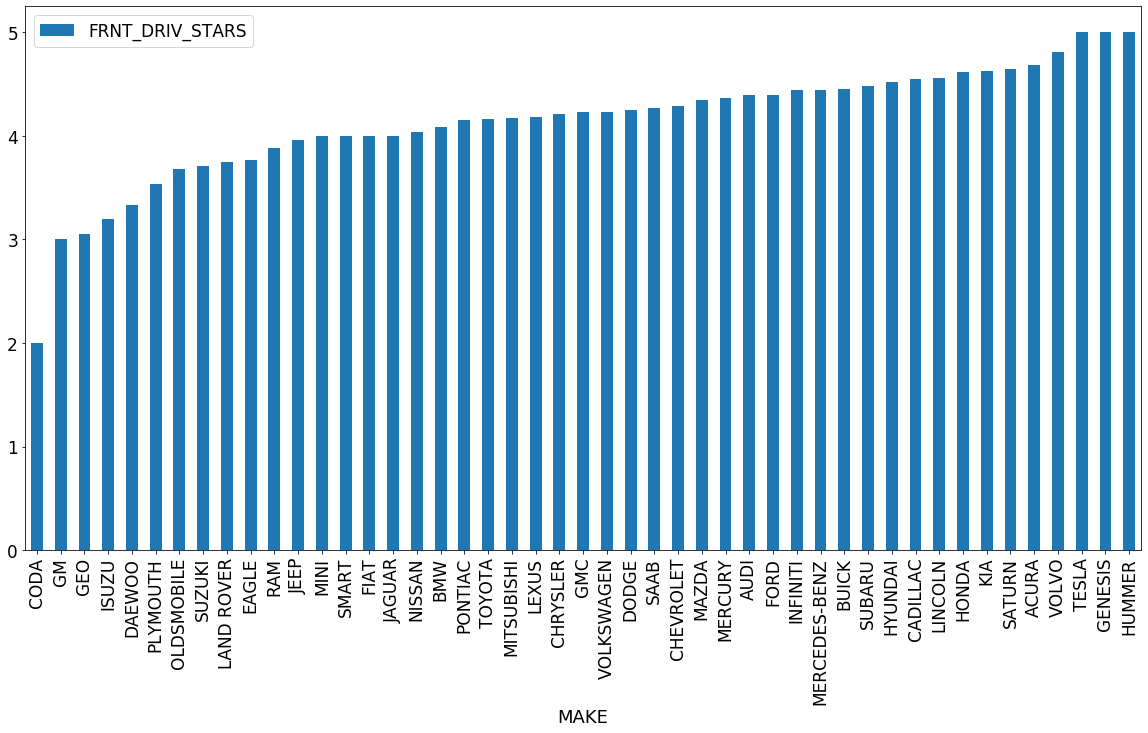

In [259]:
ncap_group_driv = ncap_group[ncap_group['FRNT_DRIV_STARS'].notnull()].sort_values('FRNT_DRIV_STARS')
ncap_group_driv[['MAKE', 'FRNT_DRIV_STARS']].plot(kind = 'bar', x = 'MAKE')


47


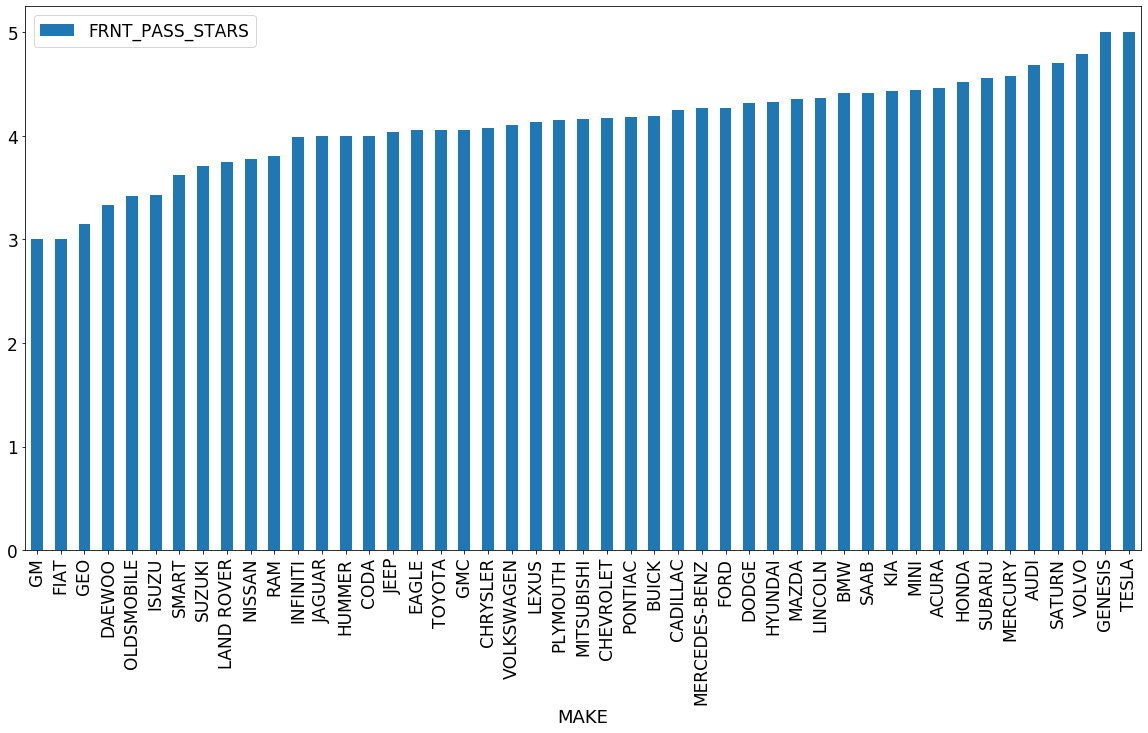

In [260]:
ncap_group_pass = ncap_group[ncap_group['FRNT_PASS_STARS'].notnull()].sort_values('FRNT_PASS_STARS')
ncap_group_pass[['MAKE', 'FRNT_PASS_STARS']].plot(kind = 'bar', x = 'MAKE')
print(len(ncap_group_pass))

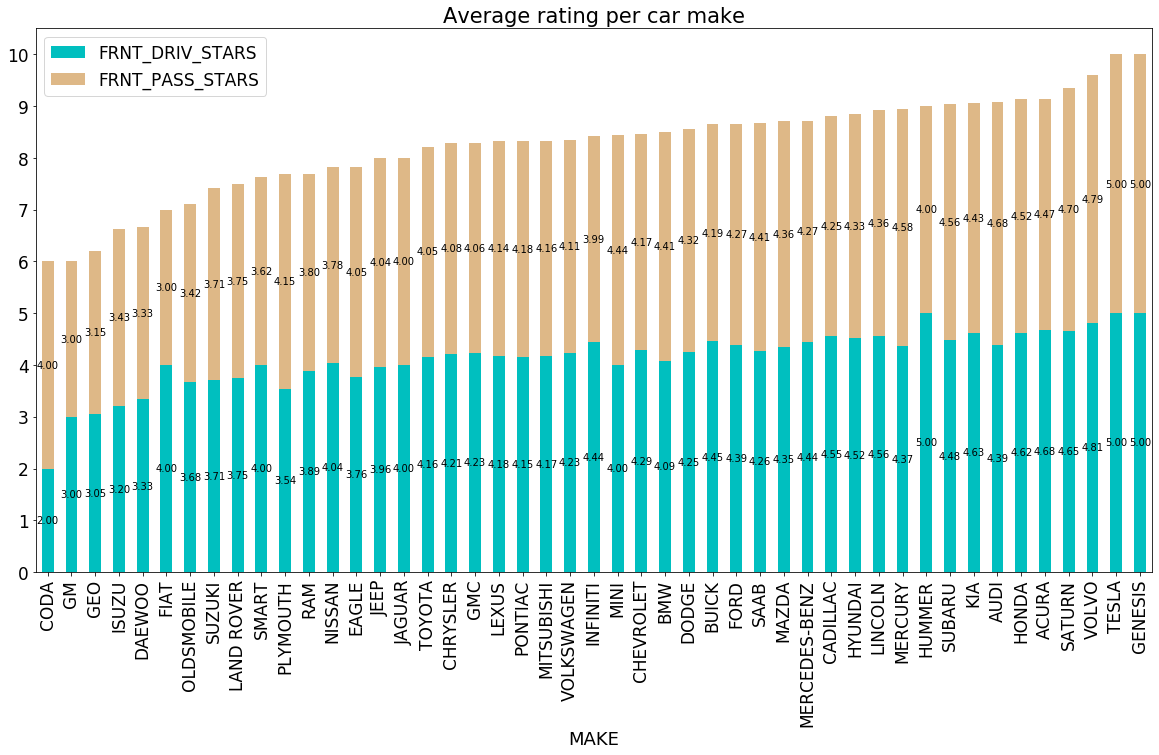

In [261]:
#df_combined = pd.merge(ncap_group_driv, ncap_group_pass, how='outer', on=['MAKE'])
#df_combined.columns = ['Vehicle_Year', 'Slight', 'Serious', 'Fatal']

df_plot = ncap_group.copy(deep = False)
df_plot['SUM'] = df_plot['FRNT_DRIV_STARS'] + df_plot['FRNT_PASS_STARS']
df_plot = df_plot.sort_values(by='SUM')[['MAKE', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS']]
df_plot = df_plot[df_plot['FRNT_DRIV_STARS'].notnull()]
plot = df_plot.plot(kind='bar',
                          x='MAKE',
                          logy=False,
                          stacked=True,
                          yticks = range(0,11,1),
                          color = ['c', 'burlywood'],
                          title='Average rating per car make')
for p in plot.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plot.text(x+width/2, 
            y+height/2, 
            '{:.2f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
# for p in plot.patches: 
#     plot.annotate(np.round(p.get_height(),decimals=1), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
display(plot)

In [262]:
ncap_group = minimized_ratings.groupby('MODEL_YR').agg('mean').reset_index()
ncap_group

,MODEL_YR,FRNT_DRIV_STARS,FRNT_PASS_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT
0,1990,3.069,3.444,nan,nan,nan,nan,67.769,3.508,3.754
1,1991,3.085,3.554,nan,nan,nan,nan,96.644,3.515,3.931
2,1992,3.346,3.978,nan,nan,nan,nan,121.292,3.009,3.028
3,1993,3.436,3.860,nan,nan,nan,nan,159.063,3.528,2.951
4,1994,3.724,3.540,nan,nan,nan,nan,219.624,4.316,2.778
5,1995,3.808,3.567,nan,nan,nan,nan,270.262,4.746,2.778
6,1996,3.872,3.613,nan,nan,nan,nan,221.577,4.739,2.317
7,1997,3.846,3.847,2.780,2.875,nan,nan,255.980,5.141,2.255
8,1998,3.809,3.892,2.679,3.000,nan,nan,329.743,5.943,2.305
9,1999,3.828,4.061,3.522,3.600,nan,nan,353.310,5.504,2.009


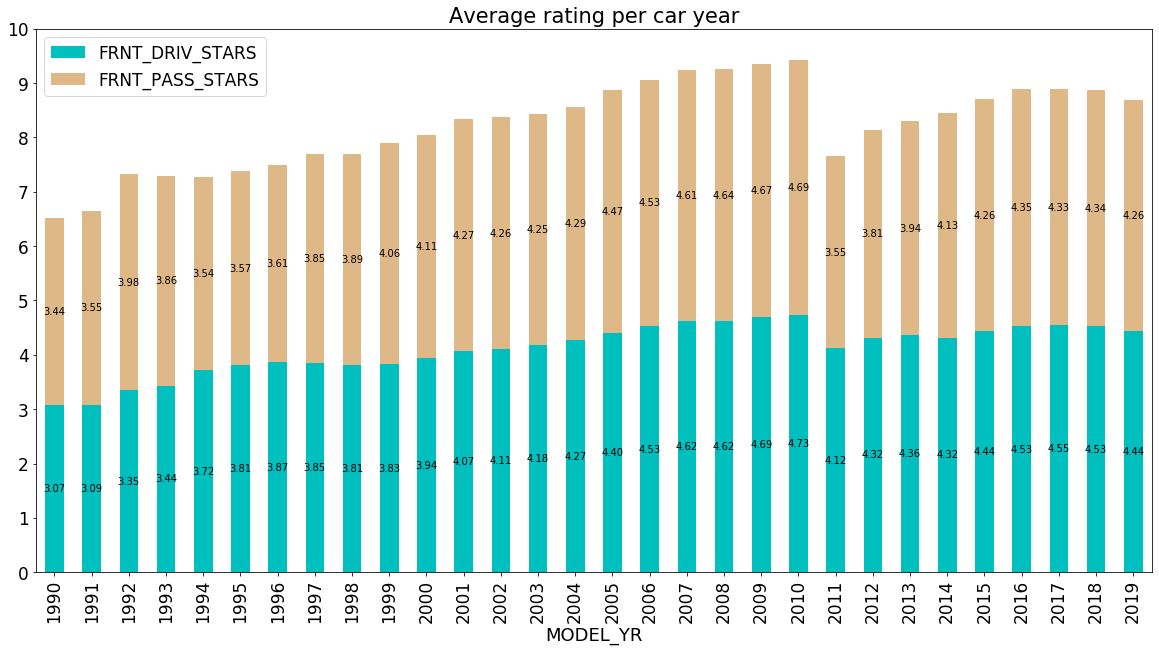

In [263]:
#df_combined = pd.merge(ncap_group_driv, ncap_group_pass, how='outer', on=['MAKE'])
#df_combined.columns = ['Vehicle_Year', 'Slight', 'Serious', 'Fatal']

df_plot = ncap_group.copy(deep = False)
df_plot['SUM'] = df_plot['FRNT_DRIV_STARS'] + df_plot['FRNT_PASS_STARS']
df_plot = df_plot.sort_values(by='MODEL_YR')[['MODEL_YR', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS']]
df_plot = df_plot[df_plot['FRNT_DRIV_STARS'].notnull()]
plot = df_plot.plot(kind='bar',
                          x='MODEL_YR',
                          logy=False,
                          stacked=True,
                          yticks = range(0,11,1),
                          color = ['c', 'burlywood'],
                          title='Average rating per car year')
for p in plot.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    plot.text(x+width/2, 
            y+height/2, 
            '{:.2f}'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
# for p in plot.patches: 
#     plot.annotate(np.round(p.get_height(),decimals=1), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
display(plot)

### NCAP vs severe UK casualties

In [253]:
df_vehicles_casualties = pd.merge(df_uk_casualties, df_matched_vehicles, on = ['Accident_Index', 'Vehicle_Reference'], how='left')

df_casualty_cars = df_vehicles_casualties[(df_vehicles_casualties.Vehicle_Model.notnull()) & (df_vehicles_casualties.Vehicle_Make.notnull())]
df_casualty_cars = df_casualty_cars[(df_casualty_cars.Casualty_Severity == 'Serious') | (df_casualty_cars.Casualty_Severity == 'Fatal')]
df_casualty_cars = df_casualty_cars[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Casualty_Severity']]

accidents_per_car = df_matched_vehicles[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Accident_Index']].groupby(['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year']).count().reset_index()
accidents_per_car.columns = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Accident_Count']

casualties_per_car = df_casualty_cars[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Casualty_Severity']].groupby(['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year']).count().reset_index()
casualties_per_car.columns = ['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Severe_Casualty_Count']

df_severe_casualties = pd.merge(accidents_per_car, casualties_per_car, on=['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year'])
df_severe_casualties['Severe_Casualties_Per_Accident'] = df_severe_casualties.Severe_Casualty_Count / df_severe_casualties.Accident_Count
df_severe_casualties = df_severe_casualties.sort_values(by='Accident_Count', ascending = False)

df_severe_casualties

KeyboardInterrupt: 

In [281]:
minimized_ratings_copy = minimized_ratings.copy(deep=False)
minimized_ratings_copy = minimized_ratings_copy.rename(columns={'MAKE': 'Vehicle_Make', 'MODEL': 'Vehicle_Model', 'MODEL_YR': 'Vehicle_Year'})
df_ncap_uk = df_severe_casualties.merge(minimized_ratings_copy, on = ['Vehicle_Year', 'Vehicle_Make', 'Vehicle_Model'], how = 'left')
df_ncap_uk

,Vehicle_Make,Vehicle_Model,Vehicle_Year,Accident_Count,Severe_Casualty_Count,Severe_Casualties_Per_Accident,FRNT_DRIV_STARS,FRNT_PASS_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,ROLLOVER_STARS,ROLLOVER_POSSIBILITY,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT
0,FORD,FOCUS,2006,3389,222,0.066,4.000,4.000,3.000,4.000,nan,nan,188.000,2.000,0.000
1,FORD,FOCUS,2005,3062,191,0.062,4.000,4.000,3.000,4.000,nan,nan,419.000,5.000,1.000
2,FORD,FOCUS,2008,2914,186,0.064,5.000,5.000,3.000,3.000,nan,nan,210.000,3.000,1.000
3,FORD,FOCUS,2007,2881,142,0.049,4.000,4.000,3.000,4.000,nan,nan,357.000,2.000,1.000
4,FORD,FOCUS,2009,2669,154,0.058,5.000,5.000,3.000,3.000,nan,nan,195.000,1.000,0.000
5,VOLKSWAGEN,GOLF,2003,2650,176,0.066,5.000,5.000,4.000,4.000,nan,nan,29.000,5.000,2.000
6,FORD,FOCUS,2004,2582,200,0.077,4.000,4.000,4.000,1.000,nan,nan,372.000,6.000,1.000
7,VOLKSWAGEN,GOLF,2004,2382,146,0.061,5.000,5.000,4.000,4.000,nan,nan,26.000,6.000,0.000
8,FORD,FOCUS,2003,2347,190,0.081,4.000,4.000,4.000,1.000,nan,nan,1004.000,7.000,1.000
9,VOLKSWAGEN,GOLF,2005,2250,124,0.055,5.000,5.000,4.000,4.000,nan,nan,16.000,4.000,0.000


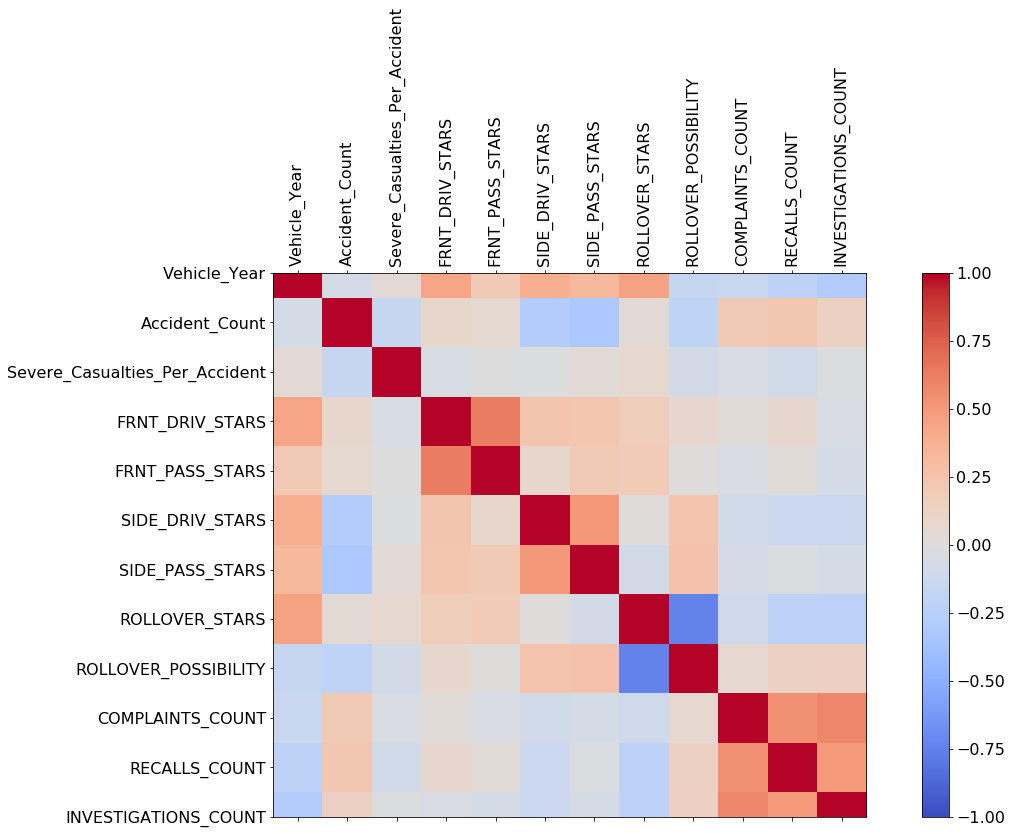

In [285]:
data = df_ncap_uk.drop(columns=['Vehicle_Make', 'Vehicle_Model', 'Severe_Casualty_Count'])
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

## NCAP Ratings with UK data

In [ ]:
df_matched_vehicles.head()

In [ ]:
df_unique_models = df_matched_vehicles.drop_duplicates(subset=['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year'])

In [ ]:
print(len(df_unique_models))

#### Getting ratings with API

In [ ]:
df_ncap_ratings = pd.DataFrame()

In [ ]:
i = 0
for index, row in df_unique_models.iterrows():
    i = i + 1
    vehicle_id = get_vehicle_id(row['Vehicle_Year'], row['Vehicle_Make'], row['Vehicle_Model'])
    print ('Cur Car #:', i, 'Cur ID:', vehicle_id)
    cur_car_rating = pd.read_csv('https://webapi.nhtsa.gov/api/SafetyRatings/VehicleId/%s?format=csv' % vehicle_id)
    if (len(df_ncap_ratings) == 0):
        df_ncap_ratings = cur_car_rating
    else:
        df_ncap_ratings = df_ncap_ratings.append(cur_car_rating)
    print('--------------------------')
    

In [ ]:
#df_ncap_ratings.to_csv('ncap_ratings.csv')
display(df_ncap_ratings)

#### finding additional missed ratings

In [ ]:
def get_vehicle_id_2(year, make, model):
    response = requests.get('https://webapi.nhtsa.gov/api/SafetyRatings/modelyear/%s/make/%s/model/%s?format=json' % (year, make, model))
    if response.status_code == 200:
        json_response = response.json()
        print(json_response['Message'])
        if int(json_response['Count']) > 1:
            return json_response['Results']
    else:
        print ('API request failed.', response.status_code)
    return '-1'

In [ ]:
final_ratings = pd.read_csv('ncap_ratings.csv', encoding = 'unicode_escape')
final_ratings = final_ratings[final_ratings.FRNT_DRIV_STARS == 'Not Rated']

In [ ]:
j_responses = []
i = 0
for index, row in final_ratings.iterrows():
    i = i+1
    print (i)
    j_responses.append(get_vehicle_id_2(row['MODEL_YR'], row['MAKE'], row['MODEL']))
    #cur_car_rating_2 = pd.read_csv('https://webapi.nhtsa.gov/api/SafetyRatings/VehicleId/%s?format=csv' % vehicle_id_2)
    

In [ ]:
filtered = list(filter(lambda x: x != '-1', j_responses))
print(filtered)

In [ ]:
new_ratings = pd.DataFrame()

In [ ]:
for entry in filtered:
    for sub_entry in entry:
        cur_car_rating = pd.read_csv('https://webapi.nhtsa.gov/api/SafetyRatings/VehicleId/%s?format=csv' % sub_entry['VehicleId'])
        print(cur_car_rating.iloc[0].FRNT_DRIV_STARS)
        if ('Not Rated' != cur_car_rating.iloc[0].FRNT_DRIV_STARS):
            
            #print (cur_car_rating)
            if (len(new_ratings) == 0):
                new_ratings = cur_car_rating
            else:
                new_ratings = new_ratings.append(cur_car_rating)
            break

In [ ]:
new_ratings = new_ratings.set_index(['MAKE', 'MODEL', 'MODEL_YR'])

In [ ]:
final_ratings = pd.read_csv('ncap_ratings.csv', encoding = 'unicode_escape')
final_ratings = final_ratings.set_index(['MAKE', 'MODEL', 'MODEL_YR'])

In [ ]:
final_ratings.update(new_ratings)

In [ ]:
display(new_ratings)

In [ ]:
#final_ratings.to_csv('final_ratings.csv')

### NCAP UK Analysis

In [42]:
df_ncap_ratings = pd.read_csv('final_ratings.csv', encoding = 'unicode_escape')

In [45]:
(df_ncap_ratings.head(50))

,MAKE,MODEL,MODEL_YR,VEHICLE_PICTURE,OVERALL_STARS,OVERALL_FRNT_STARS,FRNT_DRIV_STARS,FRNT_PASS_STARS,FRNT_FOOT_NOTES_DRIV,FRNT_FOOT_NOTES_PASS,FRNT_SAFETY_CONCERN_DRIV,FRNT_SAFETY_CONCERN_PASS,FRNT_CRASH_PICTURE,FRNT_CRASH_VIDEO,OVERALL_SIDE_STARS,SIDE_DRIV_STARS,SIDE_PASS_STARS,SIDE_FOOT_NOTES_DRIV,SIDE_FOOT_NOTES_PASS,SIDE_SAFETY_CONCERN_DRIV,SIDE_SAFETY_CONCERN_PASS,SIDE_CRASH_PICTURE,SIDE_CRASH_VIDEO,ROLLOVER_STARS,ROLLOVER_STARS_2,ROLLOVER_POSSIBILITY,ROLLOVER_POSSIBILITY_2,ROLL_FOOT_NOTES,ROLL_SAFETY_CONCERN,SIDE_POLE_STARS,POLE_FOOT_NOTES,POLE_SAFETY_CONCERN,SIDE_POLE_PICTURE,SIDE_POLE_VIDEO,NHTSA_ESC,NHTSA_FRNT_COLLISION_WARNING,NHTSA_LANE_DEPARTURE_WARNING,NHTSA_BACKUP_CAMERA,COMPLAINTS_COUNT,RECALLS_COUNT,INVESTIGATIONS_COUNT,MMY,VEHICLE_ID
0,AUDI,100,1990,NaN,Not Rated,Not Rated,5,4,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,5.000,4.000,2.000,1990 Audi 100 4-DR.,2872.000
1,BMW,325I,1990,NaN,Not Rated,Not Rated,3,Not Rated,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,12.000,2.000,1.000,1990 BMW 325i 2-DR.,2851.000
2,HONDA,PRELUDE,1990,NaN,Not Rated,Not Rated,1,3,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,4.000,1.000,0.000,1990 Honda Prelude 2-DR.,2888.000
3,ISUZU,TROOPER,1990,NaN,Not Rated,Not Rated,1,1,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,28.000,3.000,7.000,1990 Isuzu Trooper II 4-DR. 4x4,2871.000
4,NISSAN,MAXIMA,1990,NaN,Not Rated,Not Rated,3,4,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,107.000,4.000,1.000,1990 Nissan Maxima 4-DR.,2876.000
5,SUBARU,LEGACY,1990,NaN,Not Rated,Not Rated,3,4,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,84.000,4.000,3.000,1990 Subaru Legacy 4-DR.,2875.000
6,TOYOTA,CELICA,1990,NaN,Not Rated,Not Rated,3,4,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,30.000,2.000,0.000,1990 Toyota Celica 2-DR,2910.000
7,TOYOTA,COROLLA,1990,NaN,Not Rated,Not Rated,3,2,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,28.000,1.000,0.000,1990 Toyota Corolla 4-DR,2880.000
8,VOLKSWAGEN,PASSAT,1990,NaN,Not Rated,Not Rated,2,4,NaN,nan,NaN,A high femur reading was recorded for the pass...,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,35.000,2.000,0.000,1990 Volkswagen Passat 4-DR.,2869.000
9,AUDI,100,1991,NaN,Not Rated,Not Rated,5,4,NaN,nan,NaN,NaN,NaN,NaN,Not Rated,Not Rated,Not Rated,NaN,NaN,NaN,NaN,NaN,NaN,Not Rated,Not Rated,0.000,0.000,nan,nan,Not Rated,NaN,nan,NaN,NaN,No,No,No,NaN,10.000,4.000,1.000,1991 Audi 100 4-DR.,2954.000


In [68]:
df_ratings_proc = df_ncap_ratings[['MAKE', 'MODEL', 'MODEL_YR', 'OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']]
df_ratings_proc = df_ratings_proc.replace('Not Rated', np.nan)
df_ratings_proc[['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']] = df_ratings_proc[['OVERALL_STARS', 'OVERALL_FRNT_STARS', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'OVERALL_SIDE_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'SIDE_POLE_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']].astype(float)
df_ratings_proc.ROLLOVER_POSSIBILITY = df_ratings_proc.ROLLOVER_POSSIBILITY.replace(0, np.nan)
display(df_ratings_proc.info())
minimized_ratings = df_ratings_proc[['MODEL_YR', 'FRNT_DRIV_STARS', 'FRNT_PASS_STARS', 'SIDE_DRIV_STARS', 'SIDE_PASS_STARS', 'ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY', 'COMPLAINTS_COUNT', 'RECALLS_COUNT', 'INVESTIGATIONS_COUNT']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1588 entries, 0 to 1587
Data columns (total 16 columns):
MAKE                    1588 non-null object
MODEL                   1588 non-null object
MODEL_YR                1588 non-null int64
OVERALL_STARS           209 non-null float64
OVERALL_FRNT_STARS      214 non-null float64
FRNT_DRIV_STARS         962 non-null float64
FRNT_PASS_STARS         962 non-null float64
OVERALL_SIDE_STARS      216 non-null float64
SIDE_DRIV_STARS         783 non-null float64
SIDE_PASS_STARS         700 non-null float64
SIDE_POLE_STARS         217 non-null float64
ROLLOVER_STARS          516 non-null float64
ROLLOVER_POSSIBILITY    463 non-null float64
COMPLAINTS_COUNT        1588 non-null float64
RECALLS_COUNT           1588 non-null float64
INVESTIGATIONS_COUNT    1588 non-null float64
dtypes: float64(13), int64(1), object(2)
memory usage: 198.6+ KB


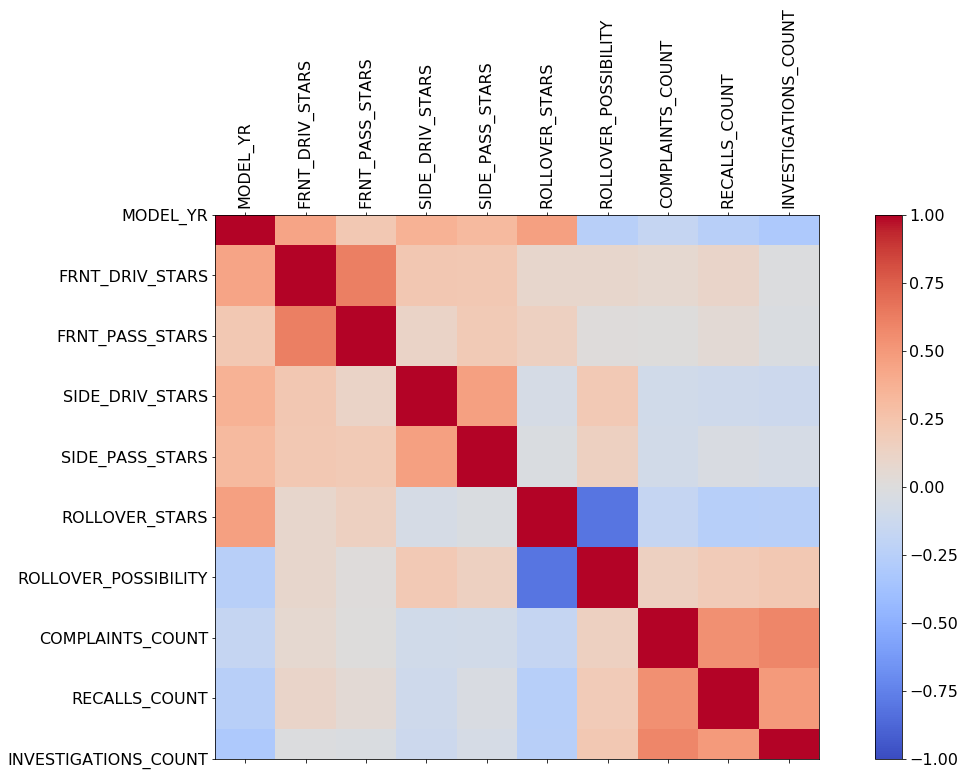

In [85]:
data = minimized_ratings
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

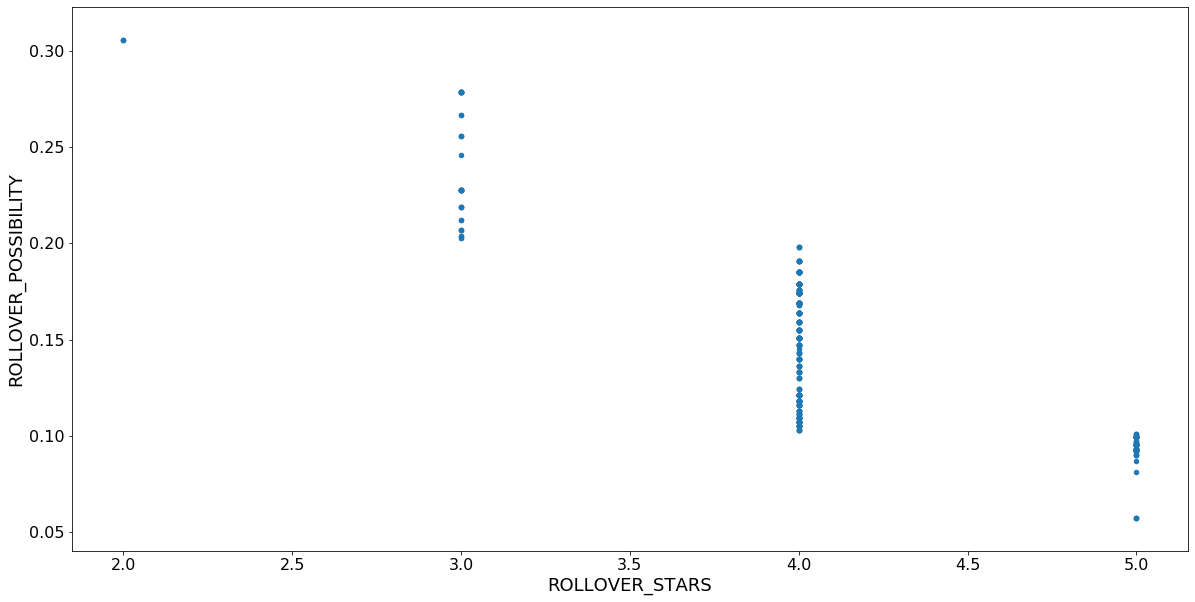

In [79]:
minimized_ratings[['ROLLOVER_STARS', 'ROLLOVER_POSSIBILITY']].plot(kind='scatter', y = 'ROLLOVER_POSSIBILITY', x = 'ROLLOVER_STARS')

In [81]:
df_vehicles_casualties

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,Vehicle_Make,Vehicle_Model,Vehicle_Year
0,2017010001708,1,1,Passenger,Female,18,4,Slight,0,0,1,0,0,9,Car,Going ahead other,0.000,0.000,0.000,0.000,0.000,0.000,Front,6.000,Male,24.000,21-25,1997.000,2.000,1.000,-1.000,NaN,NaN,2016.000
1,2017010001708,2,2,Driver or rider,Male,19,4,Serious,0,0,0,0,0,2,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,NaN,nan,NaN,nan,nan,nan,nan,NaN,NaN,nan
2,2017010001708,2,3,Passenger,Male,18,4,Fatal,0,0,0,0,0,2,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,NaN,nan,NaN,nan,nan,nan,nan,NaN,NaN,nan
3,2017010009342,1,1,Passenger,Female,33,6,Slight,0,0,1,0,0,9,Car,Going ahead other,0.000,1.000,0.000,0.000,0.000,0.000,Back,6.000,Male,33.000,26-35,1797.000,8.000,8.000,1.000,NaN,NaN,2009.000
4,2017010009344,3,1,Driver or rider,Female,31,6,Slight,0,0,0,0,0,9,Car,Going ahead other,0.000,2.000,0.000,0.000,0.000,0.000,Front,6.000,Female,31.000,26-35,1299.000,1.000,14.000,1.000,NaN,NaN,2003.000
5,2017010009348,1,1,Passenger,Male,3,1,Slight,0,0,2,0,0,9,Car,Going ahead other,0.000,4.000,0.000,9.000,0.000,0.000,Front,6.000,Female,37.000,36-45,1399.000,1.000,9.000,1.000,NaN,NaN,2008.000
6,2017010009350,1,1,Pedestrian,Male,45,7,Serious,4,3,0,0,2,0,Car,Going ahead other,0.000,2.000,0.000,0.000,0.000,0.000,Offside,6.000,Male,78.000,Over 75,1988.000,1.000,14.000,1.000,NaN,NaN,2003.000
7,2017010009351,2,1,Driver or rider,Male,14,3,Slight,0,0,0,0,0,3,NaN,NaN,nan,nan,nan,nan,nan,nan,NaN,nan,NaN,nan,NaN,nan,nan,nan,nan,NaN,NaN,nan
8,2017010009353,1,1,Driver or rider,Female,58,9,Slight,0,0,0,0,0,9,Car,Moving off,0.000,8.000,0.000,0.000,0.000,0.000,Offside,6.000,Female,58.000,56-65,1587.000,1.000,13.000,1.000,NaN,NaN,2004.000
9,2017010009353,2,2,Driver or rider,Male,27,6,Slight,0,0,0,0,0,9,Car,Going ahead other,0.000,8.000,0.000,0.000,0.000,0.000,Front,6.000,Male,27.000,26-35,1797.000,8.000,5.000,1.000,NaN,NaN,2012.000


In [88]:
df_vehicles_casualties[[]]
uk_minimized = df_vehicles_casualties[['Vehicle_Make', 'Vehicle_Model', 'Vehicle_Year', 'Engine_Capacity_(CC)', ]]

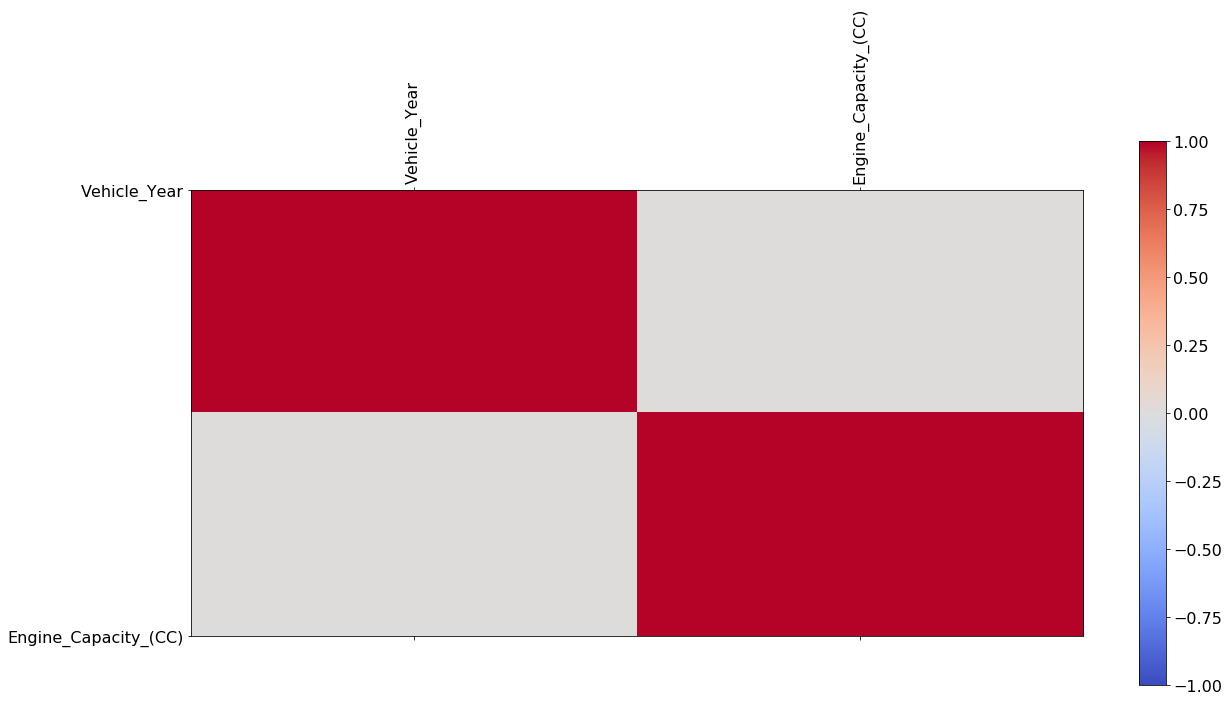

In [89]:
data = uk_minimized
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

### Serious and fatal casualty counts per accudent for cars with more than 100 collisions

In [169]:
for index, entry in accidents_per_model.iterrows():
    display(casualties_per_model.get_group('PUNTO ACTIVE'))

# df_casualty_cars = df_casualty_cars[['Vehicle_Model', 'Casualty_Severity']]
# df_plot = df_casualty_cars.groupby(['Vehicle_Model'])
# #df_plot.Casualty_Severity = df_plot.Casualty_Severity.astype(int)
# #display(df_plot.dtypes)
# #df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_accidents[['Accident_Index', 'Date']], on = ['Accident_Index'], how='left')
# for g, data in df_plot:
#     display(data)
#     break
# #     for index, entry in data.iterrows():
# #         print(entry['Vehicle_Model'])
        
    


# for index, entry in df_plot.iterrows():
#     print(entry.keys())
#     break
#     cur_count = accidents_per_model[accidents_per_model['index'] == entry['Name']].iloc[0]
#     print (cur_count, entry['Name'])
    
# df_plot.Casualty_Severity /= accidents_per_model[accidents_per_model['index'] == ]
# display(df_plot.sort_values(by='Casualty_Severity', ascending=False))
# df_plot_slight.columns = ['Vehicle_Year', 'Count']
# df_plot_slight = df_plot_slight.sort_values(by='Vehicle_Year', ascending=False)

# for i in range(int(accidents_per_year.Vehicle_Year.min()), int(accidents_per_year.Vehicle_Year.max()) + 1):
#     if len(accidents_per_year[accidents_per_year.Vehicle_Year == i]) > 0:
#         yearly_accidents = (accidents_per_year[accidents_per_year.Vehicle_Year == i].Count.iloc[0])
    
#     if len(df_plot_slight[df_plot_slight.Vehicle_Year == i]) > 0:
#         df_plot_slight.Count = np.where(df_plot_slight.Vehicle_Year == i, df_plot_slight.Count / yearly_accidents, df_plot_slight.Count)


,Vehicle_Model,Casualty_Severity
157368,PUNTO ACTIVE,Serious
180904,PUNTO ACTIVE,Serious
183866,PUNTO ACTIVE,Serious
183867,PUNTO ACTIVE,Serious
190100,PUNTO ACTIVE,Serious
193665,PUNTO ACTIVE,Serious
195941,PUNTO ACTIVE,Serious
198051,PUNTO ACTIVE,Serious
202166,PUNTO ACTIVE,Serious
203165,PUNTO ACTIVE,Serious
